# Terrain Classification - Kevin's Power Data
### Created by Keenan McConkey 2019.08.01

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_power/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Kevin' not in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Middle_GrassPowerStraightKevin_Module6050',
 'Middle_ConcretePowerDonutKevin_Module6050',
 'Middle_SidewalkPowerStraightKevin_Module6050',
 'Middle_SidewalkPowerF8Kevin_Module6050',
 'Middle_SidewalkPowerDonutKevin_Module6050',
 'Middle_CarpetPowerDonutKevin_Module6050',
 'Middle_ConcretePowerF8Kevin_Module6050',
 'Middle_CarpetPowerStraightKevin_Module6050',
 'Middle_GravelPowerF8Kevin_Module6050',
 'Middle_AsphaltPowerF8Kevin_Module6050',
 'Middle_AsphaltPowerStraightKevin_Module6050',
 'Middle_GrassPowerDonutKevin_Module6050',
 'Middle_AsphaltPowerDonutKevin_Module6050',
 'Middle_LinoleumPowerStraightKevin_Module6050',
 'Middle_GrassPowerF8Kevin_Module6050',
 'Middle_ConcretePowerStraightKevin_Module6050',
 'Middle_GravelPowerStraightKevin_Module6050',
 'Middle_LinoleumPowerDonutKevin_Module6050',
 'Middle_CarpetPowerF8Kevin_Module6050',
 'Middle_LinoleumPowerF8Kevin_Module6050',
 'Middle_GravelPowerDonutKevin_Module6050']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
57,-6.066516,-2.084728,2.873392,-0.121684,-0.404283,1.262360,0.189990,1.564176e+09
58,5.454624,0.436944,-1.535343,-0.166170,-0.389898,1.347069,0.193302,1.564176e+09
59,-2.938973,1.294264,-1.834686,0.063717,-0.168269,1.240783,0.196629,1.564176e+09
60,1.086601,-0.271902,-1.559290,-0.117955,-0.146692,1.307112,0.200002,1.564176e+09
61,-2.124758,1.356528,-1.918502,0.164942,-0.010039,1.182445,0.203326,1.564176e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

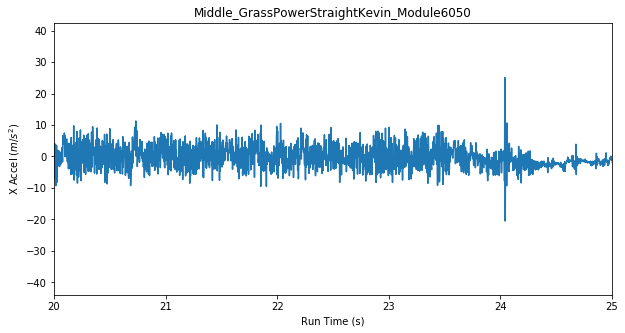

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

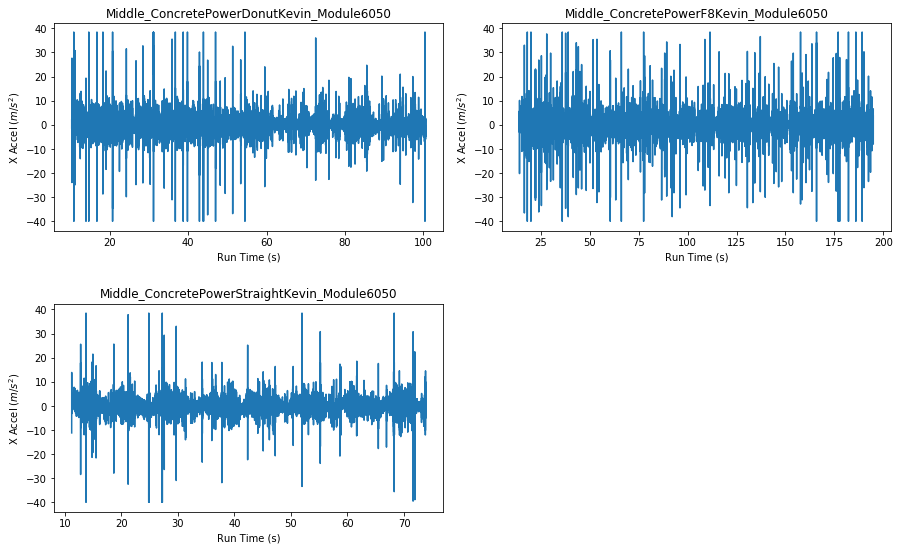

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='X Accel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 21
Shape of first dataset: (22271, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

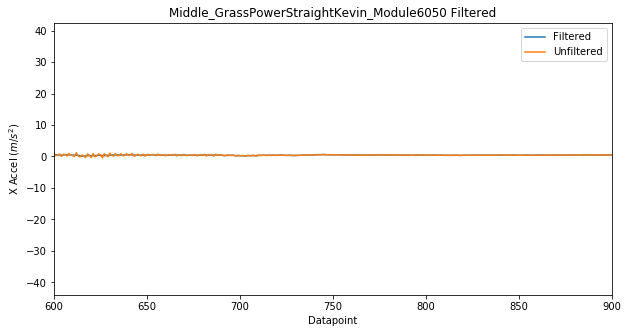

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 21
Shape of first filtered dataset: (22271, 8)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,-6.066844,-2.085471,2.873910,-0.121747,-0.404352,1.262376,0.189990,1.564176e+09
1,-1.571951,-0.310778,-0.196425,-0.083508,-0.305863,1.286458,0.193302,1.564176e+09
2,0.763785,0.733123,-2.026237,-0.039859,-0.200981,1.288018,0.196629,1.564176e+09
3,0.835362,0.961364,-2.279428,0.002618,-0.115625,1.266319,0.200002,1.564176e+09
4,0.168332,0.867196,-1.583774,0.030410,-0.090162,1.240181,0.203326,1.564176e+09


<Figure size 432x288 with 0 Axes>

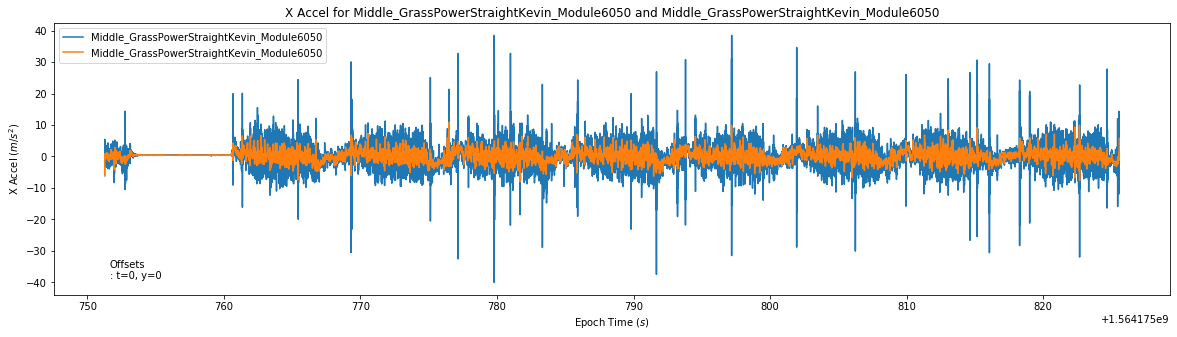

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [31]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

'\nfor terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.up

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 21
Num of windows in first dataset: 74
Shape of individual window: (300, 8)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
295,-0.143584,0.174749,1.978048,0.080242,-0.003429,2.021568,1.173936,1.564176e+09
296,-0.784879,0.221448,1.782243,0.090665,-0.041745,2.008933,1.176544,1.564176e+09
297,-0.725453,0.339131,1.046079,0.100055,-0.038787,1.997009,1.180279,1.564176e+09
298,0.057825,0.536150,0.171372,0.094393,-0.030002,1.985732,1.183924,1.564176e+09
299,0.987261,0.947595,-0.465879,0.078025,-0.053729,1.973800,1.186717,1.564176e+09


<Figure size 432x288 with 0 Axes>

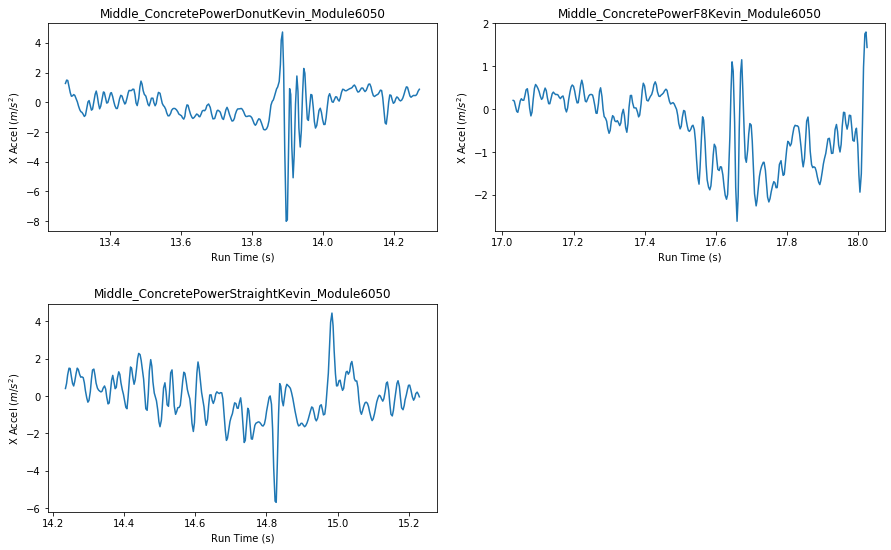

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='X Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [38]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [39]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 21
Num of FFT'd windows in first dataset: 64
Shape of FFT'd individual window: (60, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.036659,1.370341,0.009932,0.091446,0.030902,1.769672,0.0
1,0.018660,0.238083,0.036109,0.002937,0.004113,0.092383,1.0
2,0.151103,0.140010,0.127426,0.009506,0.036637,0.033316,2.0
3,0.241400,0.116399,0.058488,0.014060,0.017753,0.082213,3.0
4,0.055363,0.030055,0.044480,0.007642,0.010517,0.019452,4.0


<Figure size 432x288 with 0 Axes>

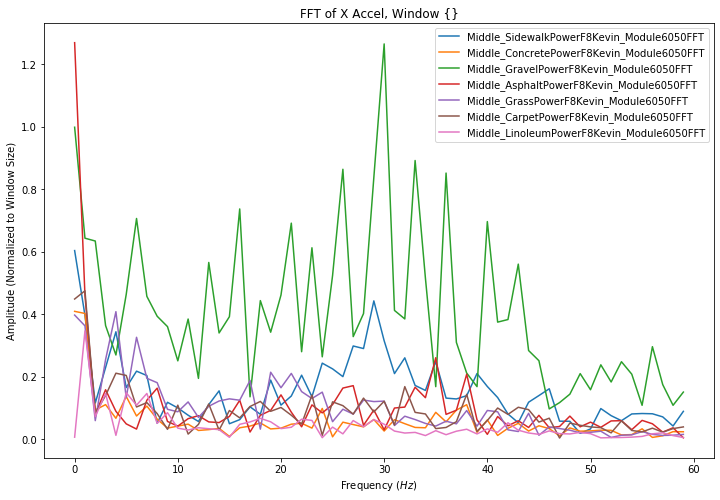

In [40]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

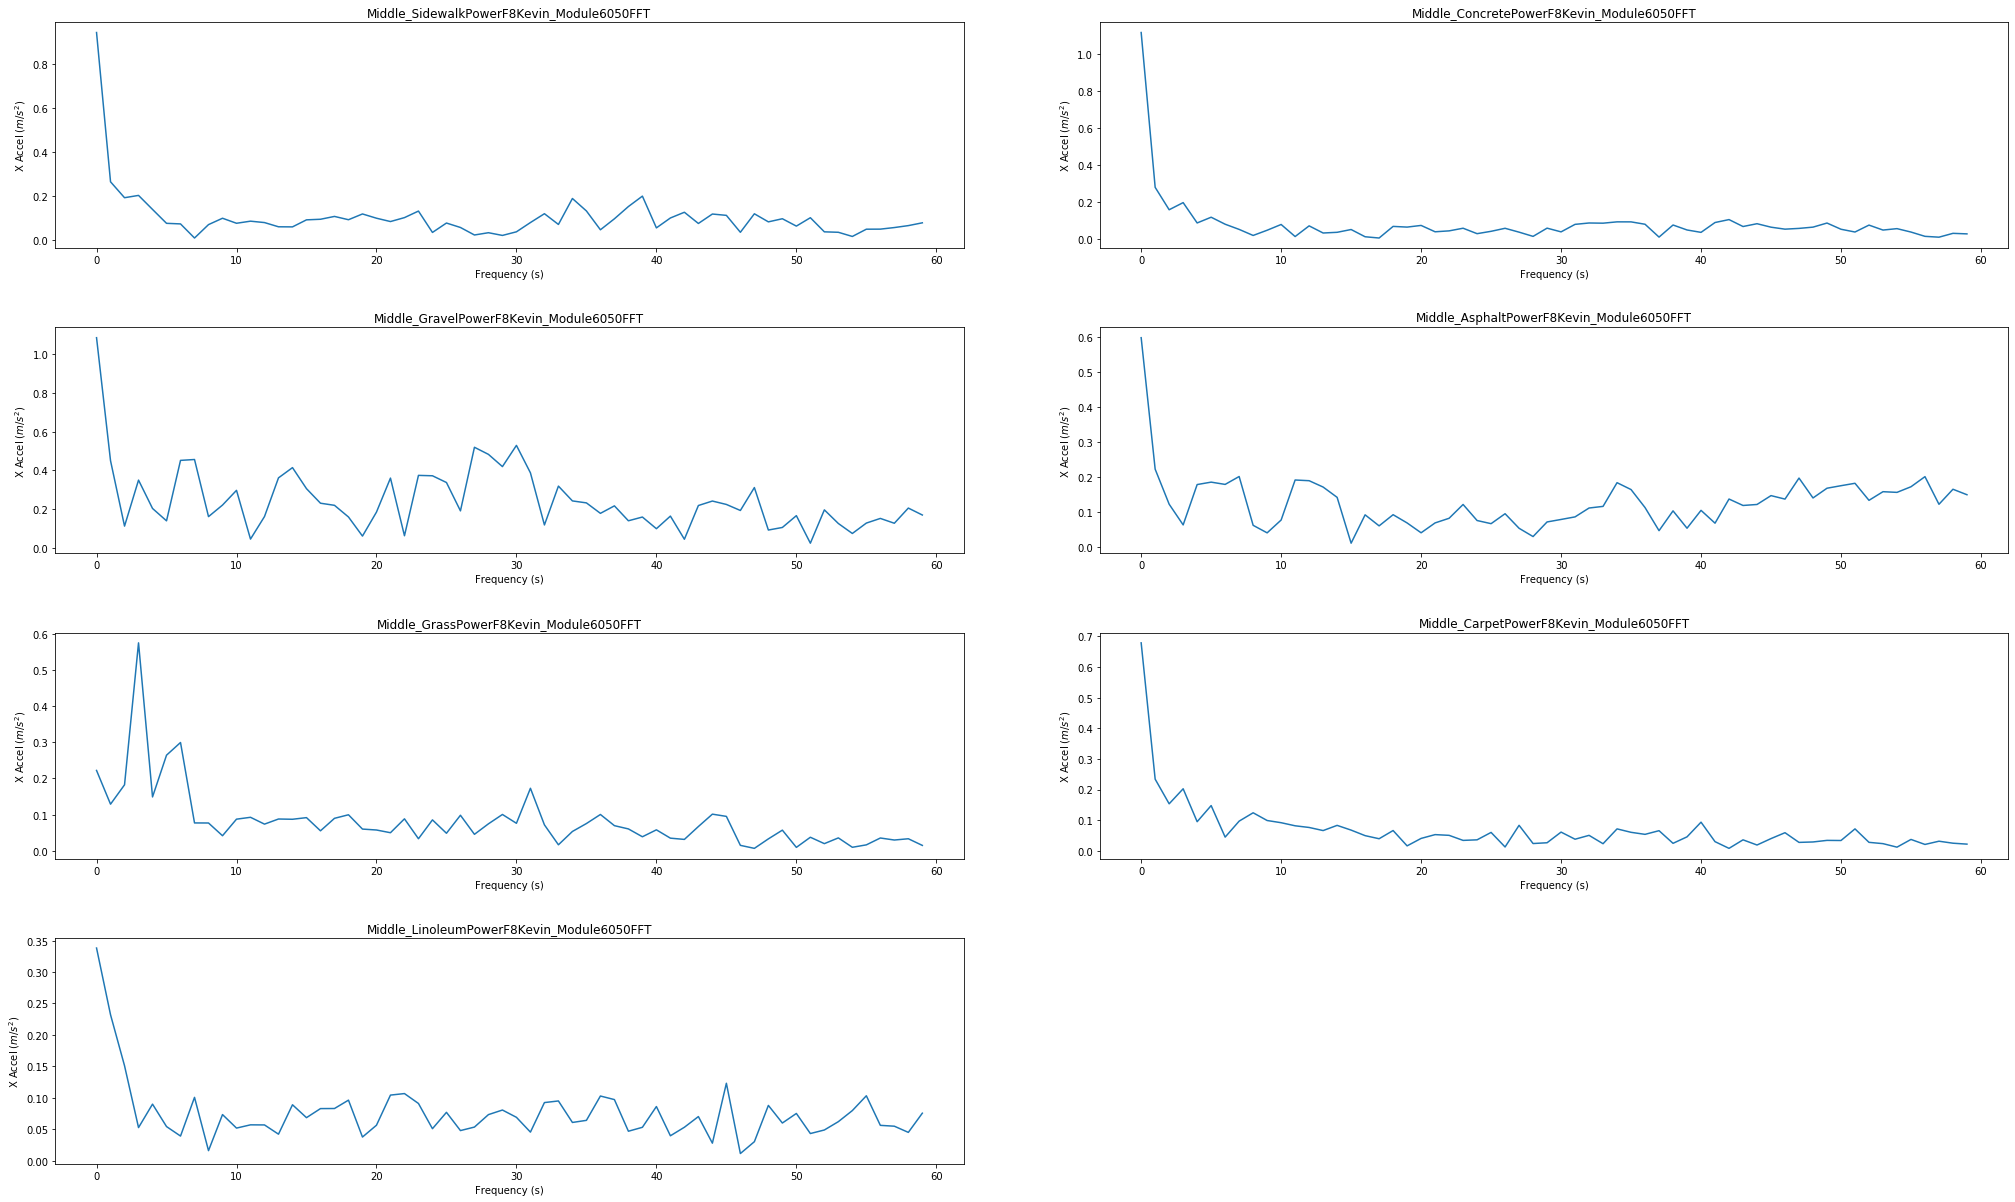

In [41]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

### Part (b) - PSD

In [42]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [43]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 21
Num of PSD'd windows in first dataset: 74
Shape of PSD'd individual window: (60, 7)


<Figure size 432x288 with 0 Axes>

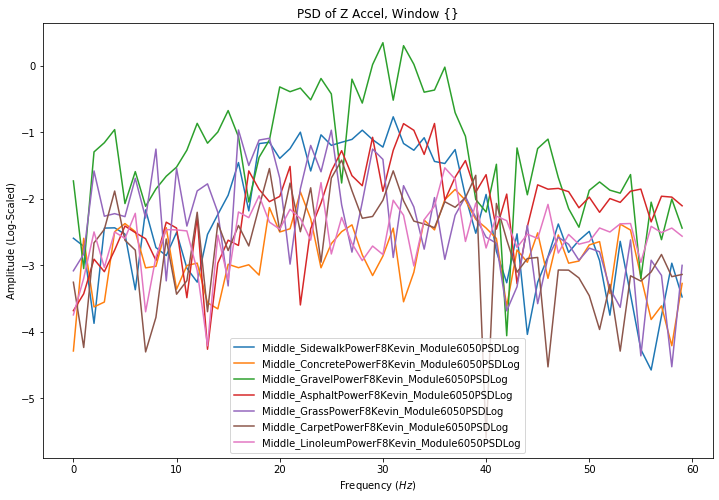

In [45]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

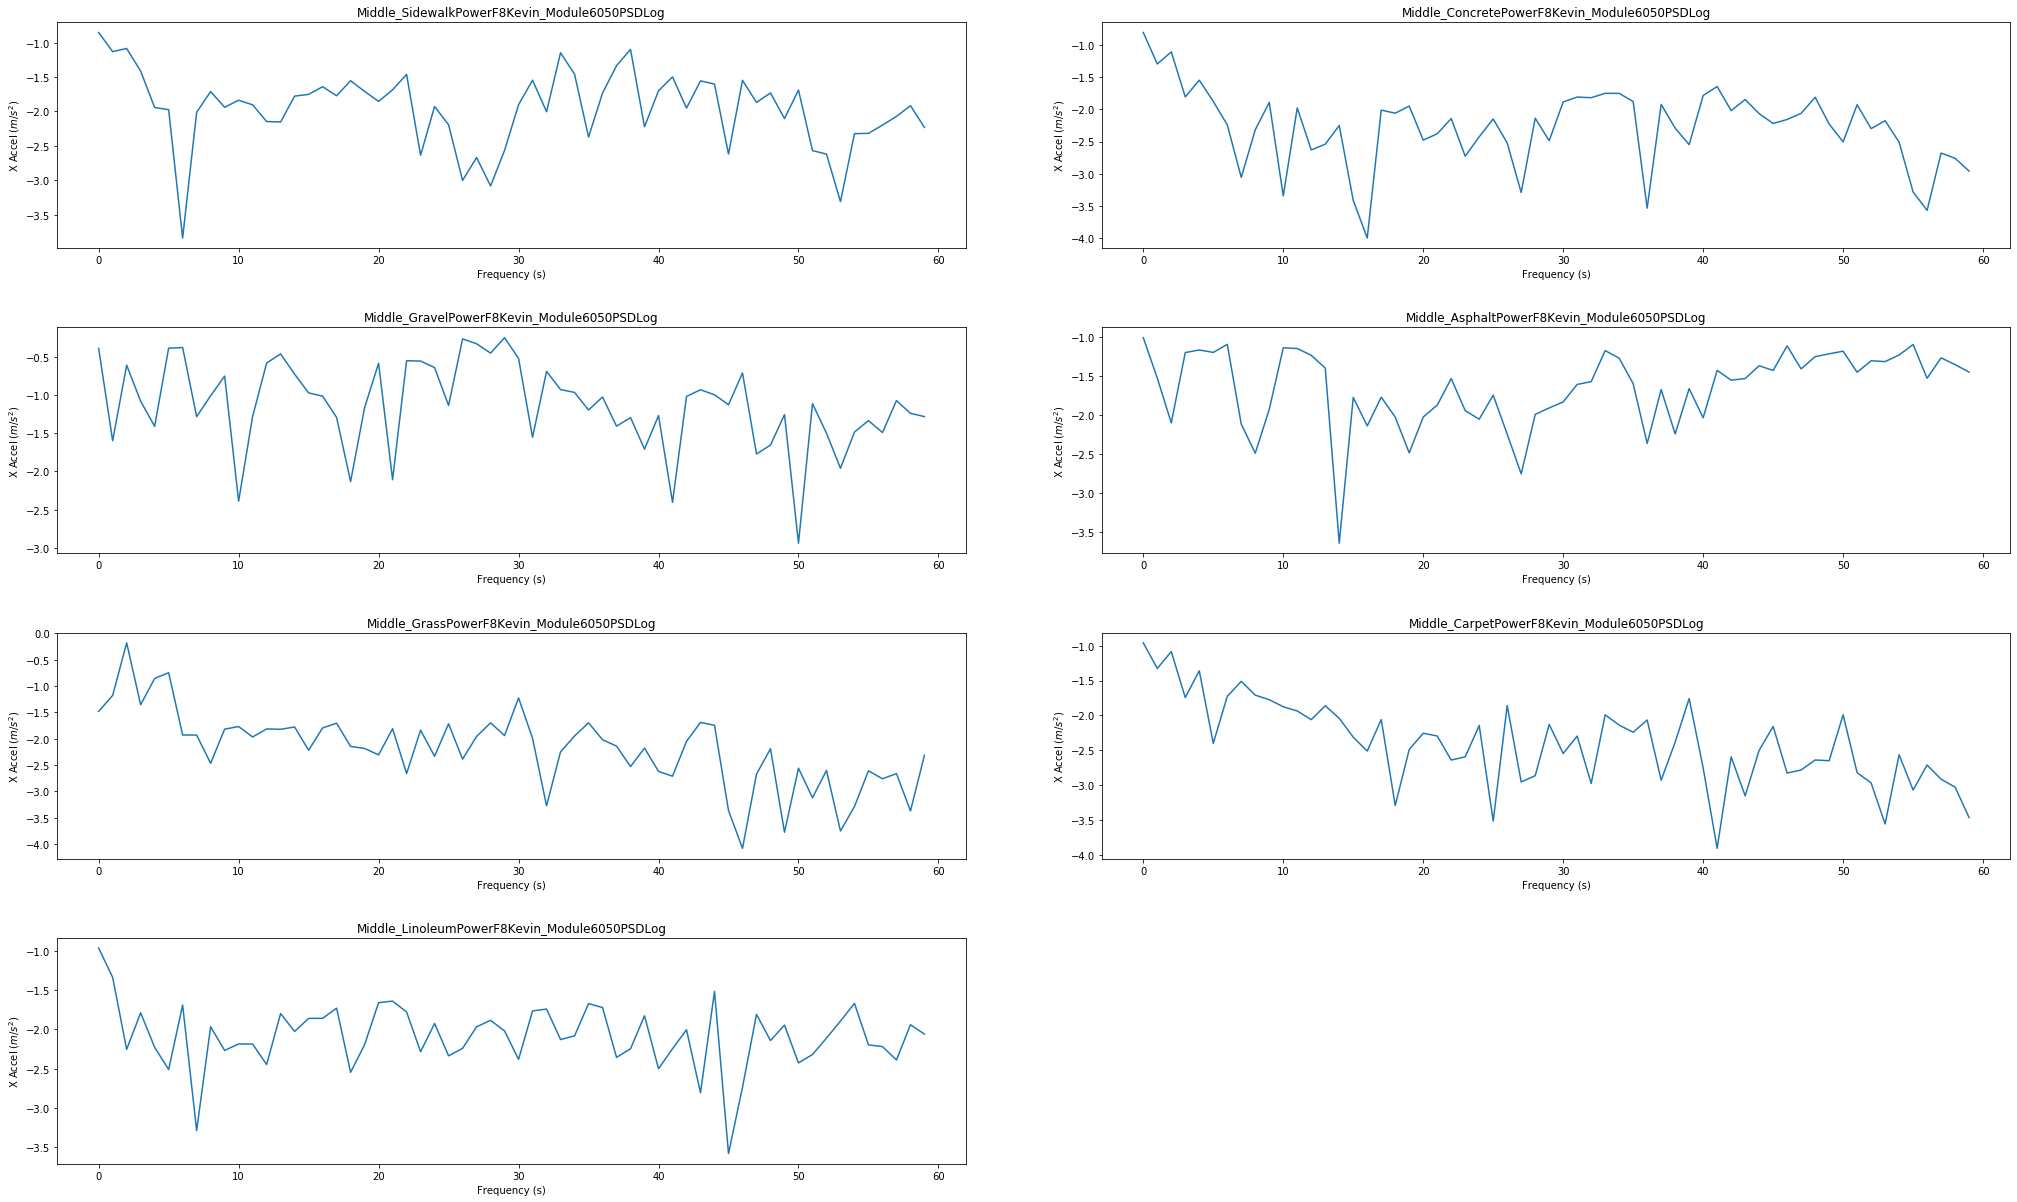

In [46]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [47]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

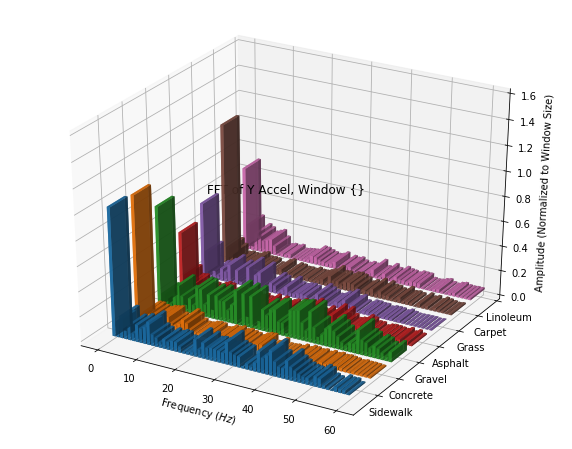

In [48]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

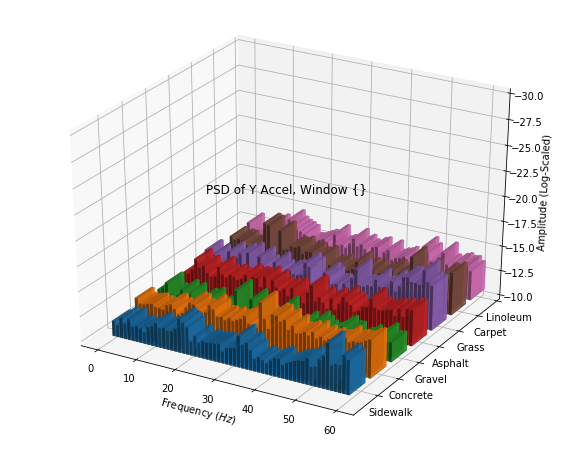

In [49]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [50]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

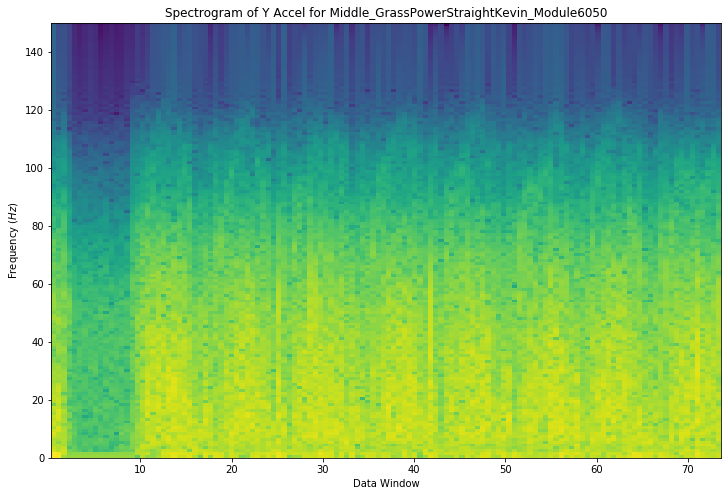

In [51]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [52]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [53]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [54]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [55]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [56]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 21
Num directions: 6
Shape of first dataset first direction: (74, 10)


<Figure size 432x288 with 0 Axes>

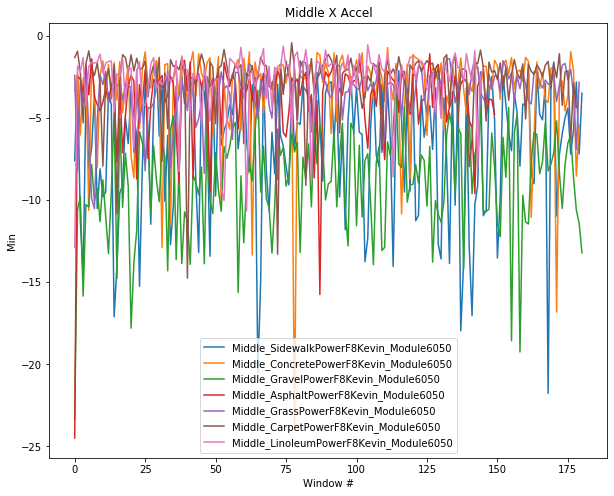

In [57]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [58]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [59]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 21
Num directions: 6
Shape of one direction: (74, 5)


<Figure size 432x288 with 0 Axes>

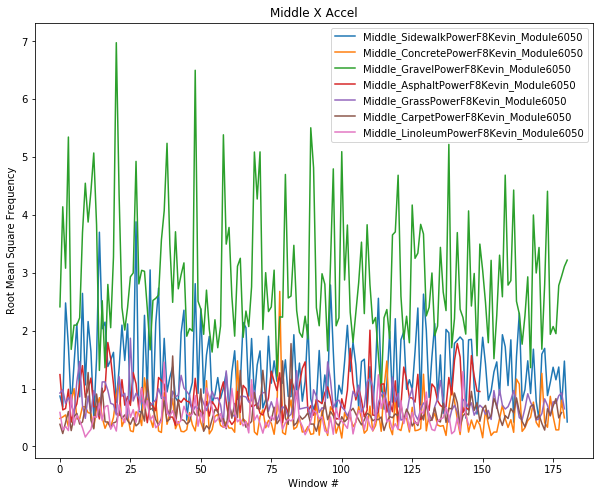

In [60]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [61]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [62]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [63]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [64]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,-0.036659,1.073850,18.610455,346.349042,2.912481,-6.066844,1.074475,0.163333,-1.279971,5.237783,0.567934,0.753614,13.609338,-184.646143,0.753614
1,-0.230658,0.996386,17.714307,313.796676,1.954567,-2.390273,1.022736,0.066667,0.053014,-0.703010,0.067800,0.260385,5.089570,-25.835918,0.260385
2,0.432685,0.074923,7.605853,57.849004,0.644727,0.093761,0.439124,0.000000,-1.039912,2.929042,0.002117,0.046012,10.843004,-117.568617,0.046012
3,0.436148,0.022992,7.564790,57.226048,0.495808,0.382216,0.436753,0.000000,-0.025851,-0.435054,0.000352,0.018766,23.883407,-570.416767,0.018766
4,0.437180,0.019722,7.579886,57.454671,0.507527,0.391520,0.437625,0.000000,0.294060,0.738218,0.000233,0.015250,19.097894,-364.729323,0.015250


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [65]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [66]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [67]:
datasets_feat_norm[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,-0.240789,-0.635484,-1.195641,-1.352221,-0.739467,-1.218421,-1.195641,1.611103,-3.109063,2.902453,-0.662032,-0.397515,0.071348,0.080411,-0.397515
1,-0.484974,-0.773944,-1.300609,-1.431244,-1.136975,0.654938,-1.300609,-0.422678,-0.326403,-0.928733,-1.341848,-1.519698,-1.895046,1.361694,-1.519698
2,0.349970,-2.420992,-2.484630,-2.052580,-1.680521,1.920652,-2.484630,-1.825285,-2.607931,1.413558,-1.431129,-2.007433,-0.567132,0.621593,-2.007433
3,0.354328,-2.513815,-2.489440,-2.054093,-1.742318,2.067632,-2.489440,-1.825285,-0.491037,-0.755930,-1.433528,-2.069424,2.442642,-3.031992,-2.069424
4,0.355628,-2.519659,-2.487671,-2.053538,-1.737455,2.072372,-2.487671,-1.825285,0.176790,0.000707,-1.433690,-2.077423,1.338127,-1.372503,-2.077423


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

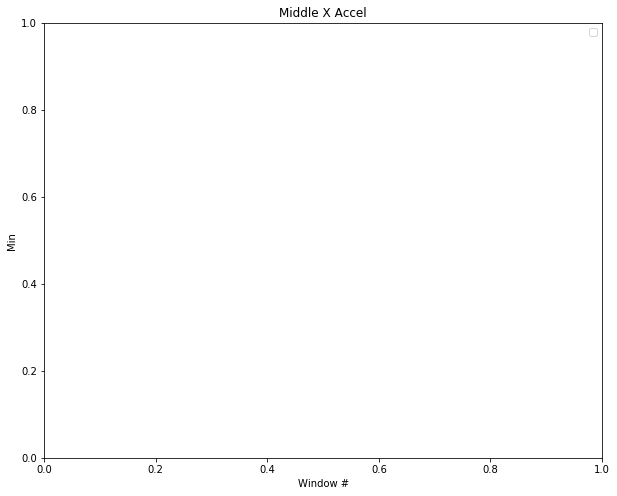

In [68]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

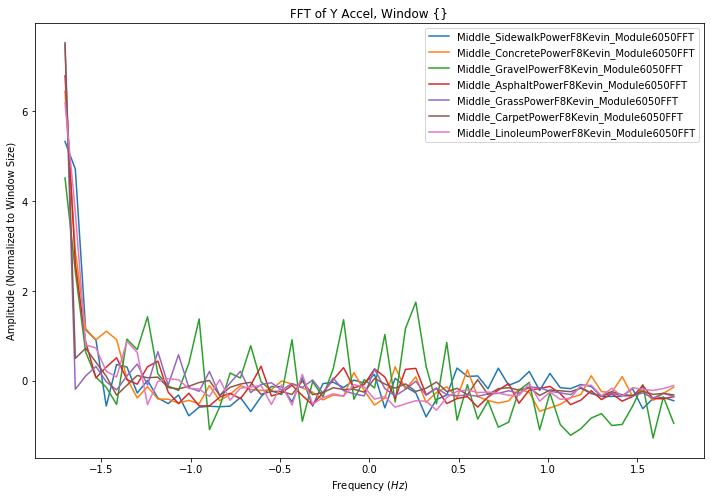

In [69]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [70]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [71]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [72]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,Excess Kurtosis X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,-0.240789,-0.635484,-1.195641,-1.352221,-0.739467,-1.218421,-1.195641,1.611103,-3.109063,2.902453,...,2.112635,2.047493,-0.978350,-1.182540,0.350631,0.771006,1.008629,0.886335,-0.697353,1.008629
1,-0.484974,-0.773944,-1.300609,-1.431244,-1.136975,0.654938,-1.300609,-0.422678,-0.326403,-0.928733,...,0.472344,1.271374,-0.584883,-0.003937,-1.142731,0.147031,0.455993,-1.097283,0.879957,0.455993
2,0.349970,-2.420992,-2.484630,-2.052580,-1.680521,1.920652,-2.484630,-1.825285,-2.607931,1.413558,...,0.776422,-0.771189,2.169384,1.398132,-0.258753,-0.815676,-1.313953,0.108357,0.150801,-1.313953
3,0.354328,-2.513815,-2.489440,-2.054093,-1.742318,2.067632,-2.489440,-1.825285,-0.491037,-0.755930,...,0.788099,-0.798508,-0.584883,0.538189,0.030838,-0.823794,-1.433629,-1.718302,0.973770,-1.433629
4,0.355628,-2.519659,-2.487671,-2.053538,-1.737455,2.072372,-2.487671,-1.825285,0.176790,0.000707,...,0.786596,-0.798087,0.595517,1.220000,0.902275,-0.823794,-1.433629,-1.718302,0.973770,-1.433629


#### Part (ii) - Transformed Data

In [73]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [74]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [75]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [76]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,FFT 58.0 Hz Z Accel Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,0.001762,0.001512,0.001104,0.025588,0.018614,0.029430,0.002061,0.001754,0.000103,0.026823,...,0.002937,0.036109,0.238083,0.018660,1.769672,0.030902,0.091446,0.009932,1.370341,0.036659
1,0.005322,0.000235,0.000737,0.005248,0.001573,0.006744,0.006065,0.000842,0.001022,0.003965,...,0.018615,0.026811,0.480341,0.549699,0.916494,0.015350,0.020068,0.011017,0.441392,0.230658
2,0.000109,0.000122,0.000085,0.002196,0.001347,0.001410,0.000124,0.000158,0.000142,0.001016,...,0.001051,0.003797,0.004864,0.007668,0.011521,0.003750,0.001409,0.022425,0.046077,0.432685
3,0.000016,0.000048,0.000021,0.001411,0.000527,0.000654,0.000041,0.000020,0.000041,0.001591,...,0.000086,0.001900,0.000881,0.000318,0.002004,0.004473,0.002376,0.022074,0.048552,0.436148
4,0.000019,0.000052,0.000029,0.000335,0.000637,0.000920,0.000014,0.000029,0.000010,0.000641,...,0.000037,0.003095,0.001928,0.003504,0.002070,0.004561,0.002404,0.026460,0.049392,0.437180
5,0.000036,0.000004,0.000029,0.001285,0.000803,0.000575,0.000017,0.000049,0.000030,0.001395,...,0.000101,0.001595,0.002168,0.000672,0.001971,0.004523,0.002718,0.021272,0.050470,0.442477
6,0.000045,0.000010,0.000044,0.000923,0.000456,0.000337,0.000014,0.000041,0.000019,0.001229,...,0.000014,0.001777,0.002701,0.002407,0.002033,0.004551,0.002641,0.026723,0.046723,0.444796
7,0.000008,0.000026,0.000014,0.000572,0.000467,0.000841,0.000005,0.000052,0.000008,0.000291,...,0.000137,0.000974,0.004440,0.006129,0.001916,0.004674,0.002734,0.026445,0.049122,0.442154
8,0.000023,0.000021,0.000021,0.000513,0.000625,0.001083,0.000047,0.000051,0.000044,0.000544,...,0.000190,0.004914,0.000994,0.005231,0.001900,0.004470,0.002564,0.025635,0.048452,0.445000
9,0.000457,0.000628,0.000797,0.010080,0.010114,0.029224,0.000765,0.000564,0.000139,0.007502,...,0.014458,0.087607,0.066702,0.547578,0.020389,0.011081,0.016366,0.049006,0.011902,1.083727


In [77]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,PSD 58.0 Hz Z Accel Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
0,-4.988654,-5.510272,-5.785747,-3.410910,-3.306724,-2.821727,-5.207072,-5.339937,-5.612954,-2.882896,...,-3.742953,-1.488453,-1.406654,-1.340421,-1.767789,-4.470743,-4.763169,-2.583731,-0.945515,-3.157162
1,-4.220201,-5.969536,-6.444523,-3.822537,-4.165499,-4.200919,-4.246849,-6.957454,-5.963511,-4.259032,...,-3.769994,-3.121929,-1.809464,-1.367838,-0.150600,-4.181322,-3.159253,-2.842334,-0.335870,-0.218720
2,-7.986989,-7.741701,-9.159657,-5.392952,-5.945512,-6.291543,-7.622772,-7.523230,-7.837084,-5.015849,...,-5.503113,-4.466593,-3.790686,-3.390294,-4.229225,-5.805358,-5.655756,-4.540095,-4.324983,-3.929598
3,-9.053301,-8.934564,-9.790065,-6.075985,-7.840020,-7.444968,-9.284641,-8.336477,-9.052306,-5.399984,...,-7.417286,-4.617932,-4.786769,-6.348579,-7.332472,-7.747773,-7.833637,-5.141376,-5.809393,-6.694891
4,-9.862285,-10.252215,-8.899028,-5.814863,-6.117644,-7.001611,-9.164534,-8.267552,-8.774319,-6.647858,...,-9.323099,-4.777285,-4.765083,-4.141165,-6.726140,-7.580305,-8.557527,-4.717705,-5.128757,-4.609773
5,-8.032339,-9.080325,-9.171258,-6.251202,-6.403560,-5.937571,-8.590543,-10.502617,-8.784404,-5.481230,...,-7.879122,-5.426343,-5.977592,-4.623712,-7.907541,-7.571482,-7.689640,-5.293717,-5.026746,-6.044143
6,-8.691913,-8.940176,-8.757008,-7.818730,-6.193264,-6.895675,-8.393799,-9.706470,-8.421484,-5.768188,...,-8.224713,-5.342112,-5.295212,-5.297940,-7.853316,-8.628092,-9.382536,-5.199771,-4.835777,-4.935933
7,-9.899108,-11.088509,-8.410246,-5.196119,-7.772449,-6.391719,-9.895454,-8.885705,-9.409712,-6.184455,...,-6.895754,-4.345773,-5.073274,-3.522967,-6.529934,-7.576603,-7.426379,-5.721780,-4.404144,-4.124183
8,-8.554224,-8.478985,-8.802141,-6.562122,-5.684151,-5.574423,-8.970658,-9.045573,-9.045553,-6.278796,...,-7.808220,-4.808002,-4.659242,-4.930113,-6.920547,-7.379205,-7.141859,-4.316163,-5.704406,-4.261735
9,-6.148384,-6.469439,-7.005079,-4.124784,-4.417833,-3.013533,-6.378587,-6.103630,-5.896173,-3.692030,...,-4.333222,-1.762680,-2.301744,-0.923288,-3.071235,-1.409757,-3.378730,-1.813894,-2.050696,-0.222077


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [78]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [79]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [80]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,5,-0.240789,-0.635484,-1.195641,-1.352221,-0.739467,-1.218421,-1.195641,1.611103,-3.109063,...,2.112635,2.047493,-0.978350,-1.182540,0.350631,0.771006,1.008629,0.886335,-0.697353,1.008629
1,5,-0.484974,-0.773944,-1.300609,-1.431244,-1.136975,0.654938,-1.300609,-0.422678,-0.326403,...,0.472344,1.271374,-0.584883,-0.003937,-1.142731,0.147031,0.455993,-1.097283,0.879957,0.455993
2,5,0.349970,-2.420992,-2.484630,-2.052580,-1.680521,1.920652,-2.484630,-1.825285,-2.607931,...,0.776422,-0.771189,2.169384,1.398132,-0.258753,-0.815676,-1.313953,0.108357,0.150801,-1.313953
3,5,0.354328,-2.513815,-2.489440,-2.054093,-1.742318,2.067632,-2.489440,-1.825285,-0.491037,...,0.788099,-0.798508,-0.584883,0.538189,0.030838,-0.823794,-1.433629,-1.718302,0.973770,-1.433629
4,5,0.355628,-2.519659,-2.487671,-2.053538,-1.737455,2.072372,-2.487671,-1.825285,0.176790,...,0.786596,-0.798087,0.595517,1.220000,0.902275,-0.823794,-1.433629,-1.718302,0.973770,-1.433629


In [81]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,5,0.001762,0.001512,0.001104,0.025588,0.018614,0.029430,0.002061,0.001754,0.000103,...,0.002937,0.036109,0.238083,0.018660,1.769672,0.030902,0.091446,0.009932,1.370341,0.036659
1,5,0.005322,0.000235,0.000737,0.005248,0.001573,0.006744,0.006065,0.000842,0.001022,...,0.018615,0.026811,0.480341,0.549699,0.916494,0.015350,0.020068,0.011017,0.441392,0.230658
2,5,0.000109,0.000122,0.000085,0.002196,0.001347,0.001410,0.000124,0.000158,0.000142,...,0.001051,0.003797,0.004864,0.007668,0.011521,0.003750,0.001409,0.022425,0.046077,0.432685
3,5,0.000016,0.000048,0.000021,0.001411,0.000527,0.000654,0.000041,0.000020,0.000041,...,0.000086,0.001900,0.000881,0.000318,0.002004,0.004473,0.002376,0.022074,0.048552,0.436148
4,5,0.000019,0.000052,0.000029,0.000335,0.000637,0.000920,0.000014,0.000029,0.000010,...,0.000037,0.003095,0.001928,0.003504,0.002070,0.004561,0.002404,0.026460,0.049392,0.437180


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [82]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [83]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [84]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Kevin_Power')

feat_combined['Middle'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
2088,6,0.080973,-1.092189,-1.239501,-1.104282,0.685012,0.980994,-1.239501,-0.779289,1.031893,...,-1.640838,1.786289,-0.516019,-1.246031,0.982029,-0.700073,-0.646539,-0.782159,0.410272,-0.646539
2089,6,0.384099,0.396864,0.334053,0.227830,1.877474,-0.067210,0.334053,-1.395314,0.195850,...,-0.665487,-0.552272,1.282675,0.854888,-0.796726,-1.126831,-1.736420,-1.110041,0.452998,-1.736420
2090,6,-0.266759,0.389184,0.298121,0.192228,-0.303935,-0.027615,0.298121,-0.984631,-0.160946,...,-1.070840,0.288294,-0.516019,0.379767,-1.294250,-1.022060,-1.317747,-1.062283,0.449001,-1.317747
2091,6,-1.104622,0.483815,0.471082,0.365822,-0.918355,-1.133899,0.471082,0.247420,-1.330658,...,-1.182487,0.623310,-0.516019,0.627671,-1.313043,-0.432417,-0.264923,-0.584156,0.367297,-0.264923
2092,6,-0.546105,-1.002903,-1.138490,-1.032723,-1.260987,0.657426,-1.138490,-1.189973,0.458283,...,-1.487580,0.500951,-0.516019,-0.340784,0.012558,-0.769734,-0.763333,-1.025038,0.445439,-0.763333


In [85]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Kevin_Power')

fft_combined['Middle'].tail()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
2088,6,0.000989,0.002139,0.000300,0.009440,0.031841,0.054399,0.000279,0.002297,0.002503,...,0.041398,0.057789,0.313652,0.594892,1.545932,0.024872,0.038826,0.010953,0.381694,0.142377
2089,6,0.000433,0.002176,0.003628,0.025135,0.076317,0.066642,0.001586,0.005729,0.003264,...,0.005802,0.008837,0.311425,0.709113,0.646670,0.009733,0.068741,0.202582,0.367069,0.307325
2090,6,0.001760,0.001653,0.003521,0.024033,0.078287,0.037279,0.002714,0.003224,0.003198,...,0.040764,0.198642,0.162812,0.851501,0.903428,0.002530,0.070842,0.098492,1.013821,0.046842
2091,6,0.003336,0.002488,0.001951,0.018838,0.041526,0.021761,0.003275,0.002188,0.001161,...,0.034488,0.052861,0.058850,0.309262,1.044554,0.016614,0.005236,0.043437,0.786802,0.502767
2092,6,0.002376,0.002955,0.001493,0.023088,0.008009,0.118434,0.001415,0.001585,0.002849,...,0.038333,0.085100,0.146337,0.608703,1.005070,0.020679,0.047261,0.093071,0.694934,0.198849


In [86]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Kevin_Power')

psd_log_combined['Middle'].tail()

,Label,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
2088,6,-4.976429,-5.227760,-5.045294,-3.202810,-2.092395,-2.265761,-5.708990,-5.038608,-6.745877,...,-2.860298,-2.083069,-1.089252,-1.202614,-1.100349,-2.238330,-2.465012,-2.175279,-0.706075,-0.150094
2089,6,-6.388598,-5.082103,-4.917759,-2.794140,-2.298824,-2.403006,-6.425557,-5.023720,-4.579657,...,-2.822313,-1.983640,-1.252438,-1.581854,-0.750782,-3.259176,-4.171814,-3.806391,-0.712262,0.002461
2090,6,-4.568201,-5.740978,-4.329612,-3.108045,-1.593772,-2.225040,-5.207711,-5.262220,-4.605715,...,-3.044061,-2.243896,-0.956376,-0.515880,-0.526514,-2.607767,-2.478416,-1.102826,-1.275600,0.161401
2091,6,-4.707793,-6.208743,-5.764975,-2.482696,-3.941063,-2.979626,-4.652576,-4.907416,-5.118361,...,-3.825461,-1.791556,-1.223449,-1.504906,-0.599721,-2.588359,-2.623623,-2.252704,-2.159483,-0.718316
2092,6,-4.920176,-5.295673,-7.217243,-2.857350,-2.896326,-1.967424,-4.947330,-4.757939,-5.350710,...,-3.698416,-1.754262,-2.365318,-0.981273,-0.592939,-3.628998,-2.531831,-1.839113,-1.368263,-0.130160


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right